In [1]:
import os
import shutil
import random
from pathlib import Path

In [2]:
# Download dataset using KaggleHub
import kagglehub

# Download the Plant Disease dataset from Kaggle
dataset_path = kagglehub.dataset_download("emmarex/plantdisease")

print("Dataset downloaded to:")
print(dataset_path)

100%|██████████| 658M/658M [00:43<00:00, 16.0MB/s] 

Extracting files...


Dataset downloaded to:
C:\Users\HP\.cache\kagglehub\datasets\emmarex\plantdisease\versions\1


In [3]:
# Locate the PlantVillage directory
DATASET_ROOT = Path(dataset_path) / "PlantVillage"

if not DATASET_ROOT.exists():
    raise FileNotFoundError("PlantVillage folder not found")

print("PlantVillage directory found")

PlantVillage directory found


In [4]:
# Define output directories and split ratios
OUTPUT_ROOT = Path("PlantVillage_split")

TRAIN_DIR = OUTPUT_ROOT / "train"
VAL_DIR   = OUTPUT_ROOT / "val"
TEST_DIR  = OUTPUT_ROOT / "test"

TRAIN_RATIO = 0.8
VAL_RATIO   = 0.1
TEST_RATIO  = 0.1

RANDOM_SEED = 42

In [5]:
# Create train / val / test folders
if OUTPUT_ROOT.exists():
    shutil.rmtree(OUTPUT_ROOT)

TRAIN_DIR.mkdir(parents=True)
VAL_DIR.mkdir(parents=True)
TEST_DIR.mkdir(parents=True)

print("Created train / val / test directories")

Created train / val / test directories


In [6]:
#Image file helper
IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png"}

def is_image_file(path):
    return path.suffix.lower() in IMAGE_EXTENSIONS


In [7]:
# Get class folders
class_folders = [d for d in DATASET_ROOT.iterdir() if d.is_dir()]

print(f"Total classes found: {len(class_folders)}")
print("Sample classes:")
for c in class_folders[:5]:
    print("-", c.name)


Total classes found: 16
Sample classes:
- Pepper__bell___Bacterial_spot
- Pepper__bell___healthy
- PlantVillage
- Potato___Early_blight
- Potato___healthy


In [8]:
# Split function
def split_images(images, train_ratio, val_ratio):
    total = len(images)

    train_end = int(total * train_ratio)
    val_end   = train_end + int(total * val_ratio)

    train_imgs = images[:train_end]
    val_imgs   = images[train_end:val_end]
    test_imgs  = images[val_end:]

    return train_imgs, val_imgs, test_imgs


In [9]:
# Split dataset into train / val / test
random.seed(RANDOM_SEED)

for class_dir in class_folders:
    class_name = class_dir.name

    images = [img for img in class_dir.iterdir()
              if img.is_file() and is_image_file(img)]

    if len(images) == 0:
        print(f"Skipping empty class: {class_name}")
        continue

    random.shuffle(images)

    train_imgs, val_imgs, test_imgs = split_images(
        images, TRAIN_RATIO, VAL_RATIO
    )

    (TRAIN_DIR / class_name).mkdir()
    (VAL_DIR / class_name).mkdir()
    (TEST_DIR / class_name).mkdir()

    for img in train_imgs:
        shutil.copy2(img, TRAIN_DIR / class_name / img.name)

    for img in val_imgs:
        shutil.copy2(img, VAL_DIR / class_name / img.name)

    for img in test_imgs:
        shutil.copy2(img, TEST_DIR / class_name / img.name)

    print(
        f"{class_name}: "
        f"train={len(train_imgs)}, "
        f"val={len(val_imgs)}, "
        f"test={len(test_imgs)}"
    )

Pepper__bell___Bacterial_spot: train=797, val=99, test=101
Pepper__bell___healthy: train=1182, val=147, test=149
Skipping empty class: PlantVillage
Potato___Early_blight: train=800, val=100, test=100
Potato___healthy: train=121, val=15, test=16
Potato___Late_blight: train=800, val=100, test=100
Tomato_Bacterial_spot: train=1701, val=212, test=214
Tomato_Early_blight: train=800, val=100, test=100
Tomato_healthy: train=1272, val=159, test=160
Tomato_Late_blight: train=1527, val=190, test=192
Tomato_Leaf_Mold: train=761, val=95, test=96
Tomato_Septoria_leaf_spot: train=1416, val=177, test=178
Tomato_Spider_mites_Two_spotted_spider_mite: train=1340, val=167, test=169
Tomato__Target_Spot: train=1123, val=140, test=141
Tomato__Tomato_mosaic_virus: train=298, val=37, test=38
Tomato__Tomato_YellowLeaf__Curl_Virus: train=2566, val=320, test=322


In [10]:
# Verify split counts
def count_images(folder):
    return sum(len(files) for _, _, files in os.walk(folder))

print("Final image counts:")
print("Train:", count_images(TRAIN_DIR))
print("Validation:", count_images(VAL_DIR))
print("Test:", count_images(TEST_DIR))

Final image counts:
Train: 16504
Validation: 2058
Test: 2076


In [11]:
# Stage 2: Feature Engineering
# ----------------------------
# Imports for feature extraction
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

In [13]:
# Image loading & resizing
def load_image(path, size=(128, 128)):
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img

In [14]:
# Color feature extraction
def extract_color_features(img):
    features = []

    # RGB statistics
    for i in range(3):
        channel = img[:, :, i]
        features.append(np.mean(channel))
        features.append(np.std(channel))

    # HSV statistics
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    for i in range(3):
        channel = hsv[:, :, i]
        features.append(np.mean(channel))
        features.append(np.std(channel))

    return features

In [15]:
# Texture feature extraction (GLCM)
def extract_texture_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    glcm = graycomatrix(
        gray,
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True
    )

    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'dissimilarity')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ]

    return features

In [16]:
# Combine features
def extract_features(image_path):
    img = load_image(image_path)

    color_feats = extract_color_features(img)
    texture_feats = extract_texture_features(img)

    return color_feats + texture_feats

In [17]:
# Prepare dataset loader
def load_dataset(split_dir):
    X = []
    y = []

    for class_dir in split_dir.iterdir():
        if not class_dir.is_dir():
            continue

        label = class_dir.name

        for img_path in class_dir.iterdir():
            if img_path.suffix.lower() not in {".jpg", ".png", ".jpeg"}:
                continue

            features = extract_features(img_path)
            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)

In [18]:
# Extract features for all splits
X_train, y_train = load_dataset(TRAIN_DIR)
X_val, y_val     = load_dataset(VAL_DIR)
X_test, y_test   = load_dataset(TEST_DIR)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (16504, 17)
Validation: (2058, 17)
Test: (2076, 17)


In [19]:
# Stage 3 — Random Forest Training
# --------------------------------
# Imports
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [20]:
# Encode class labels
label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

print("Number of classes:", len(label_encoder.classes_))

Number of classes: 15


In [21]:
# Feature scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [22]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train_enc)

print("Random Forest training complete")

Random Forest training complete


In [23]:
# Validate Model
y_val_pred = rf_model.predict(X_val_scaled)

val_accuracy = accuracy_score(y_val_enc, y_val_pred)
print("Validation accuracy:", val_accuracy)

print("\nValidation classification report:")
print(classification_report(y_val_enc, y_val_pred, target_names=label_encoder.classes_))

Validation accuracy: 0.8304178814382897

Validation classification report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.72      0.74      0.73        99
                     Pepper__bell___healthy       0.82      0.76      0.79       147
                      Potato___Early_blight       0.90      0.94      0.92       100
                       Potato___Late_blight       0.71      0.77      0.74       100
                           Potato___healthy       0.80      0.27      0.40        15
                      Tomato_Bacterial_spot       0.88      0.89      0.89       212
                        Tomato_Early_blight       0.67      0.60      0.63       100
                         Tomato_Late_blight       0.83      0.79      0.81       190
                           Tomato_Leaf_Mold       0.90      0.82      0.86        95
                  Tomato_Septoria_leaf_spot       0.83      0.87      0.85

In [24]:
# Final evaluatiion
# -----------------
# Final Test
from sklearn.metrics import accuracy_score, classification_report

y_test_pred = rf_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test_enc, y_test_pred)
print("Test accuracy:", test_accuracy)

print("\nTest classification report:")
print(
    classification_report(
        y_test_enc,
        y_test_pred,
        target_names=label_encoder.classes_
    )
)

Test accuracy: 0.8453757225433526

Test classification report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.80      0.73      0.76       101
                     Pepper__bell___healthy       0.79      0.79      0.79       149
                      Potato___Early_blight       0.82      0.94      0.88       100
                       Potato___Late_blight       0.70      0.77      0.73       100
                           Potato___healthy       1.00      0.31      0.48        16
                      Tomato_Bacterial_spot       0.89      0.92      0.90       214
                        Tomato_Early_blight       0.68      0.57      0.62       100
                         Tomato_Late_blight       0.82      0.79      0.80       192
                           Tomato_Leaf_Mold       0.91      0.83      0.87        96
                  Tomato_Septoria_leaf_spot       0.81      0.86      0.83       178
T

In [25]:
# Feature Importance Analysis
import numpy as np

feature_names = (
    ["R_mean","R_std","G_mean","G_std","B_mean","B_std"] +
    ["H_mean","H_std","S_mean","S_std","V_mean","V_std"] +
    ["GLCM_contrast","GLCM_dissimilarity","GLCM_homogeneity",
     "GLCM_energy","GLCM_correlation"]
)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

for i in indices[:10]:
    print(f"{feature_names[i]:25s}: {importances[i]:.4f}")

H_mean                   : 0.1150
S_std                    : 0.0899
H_std                    : 0.0829
GLCM_dissimilarity       : 0.0618
S_mean                   : 0.0605
GLCM_contrast            : 0.0601
R_std                    : 0.0579
B_std                    : 0.0569
GLCM_correlation         : 0.0548
GLCM_homogeneity         : 0.0530


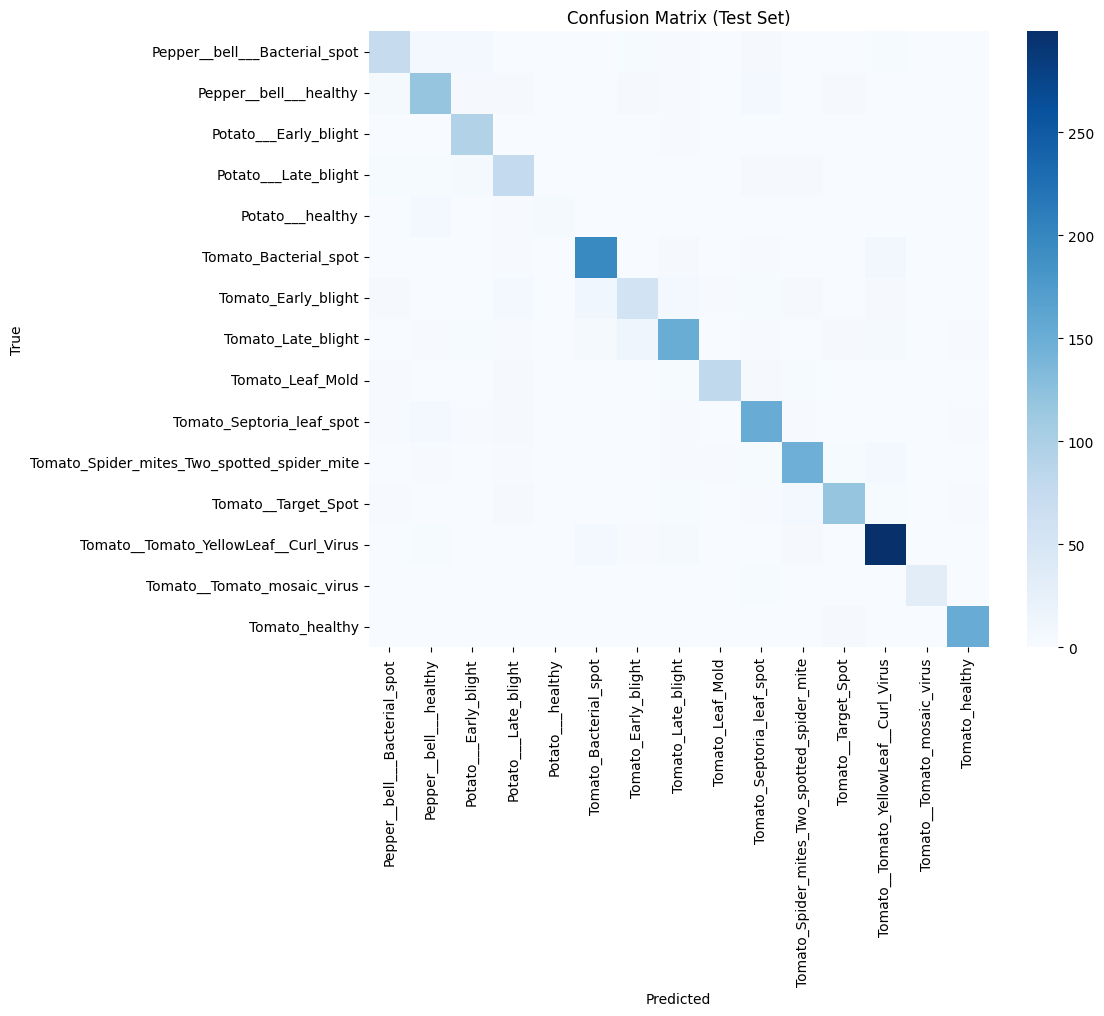

In [26]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cmap="Blues",
    fmt="d"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [27]:
# Retrain Random Forest with class weighting
# ------------------------------------------
# Training
rf_balanced = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_balanced.fit(X_train_scaled, y_train_enc)

print("Balanced Random Forest training complete")

Balanced Random Forest training complete


In [28]:
# Validate the balanced model
from sklearn.metrics import accuracy_score, classification_report

y_val_pred_bal = rf_balanced.predict(X_val_scaled)

val_acc_bal = accuracy_score(y_val_enc, y_val_pred_bal)
print("Validation accuracy (balanced):", val_acc_bal)

print("\nValidation classification report (balanced):")
print(
    classification_report(
        y_val_enc,
        y_val_pred_bal,
        target_names=label_encoder.classes_
    )
)

Validation accuracy (balanced): 0.8367346938775511

Validation classification report (balanced):
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.71      0.76      0.74        99
                     Pepper__bell___healthy       0.82      0.78      0.80       147
                      Potato___Early_blight       0.90      0.93      0.92       100
                       Potato___Late_blight       0.73      0.77      0.75       100
                           Potato___healthy       0.67      0.40      0.50        15
                      Tomato_Bacterial_spot       0.88      0.90      0.89       212
                        Tomato_Early_blight       0.72      0.63      0.67       100
                         Tomato_Late_blight       0.85      0.81      0.83       190
                           Tomato_Leaf_Mold       0.88      0.83      0.85        95
                  Tomato_Septoria_leaf_spot       0.

In [29]:
# Final Test Evaluation (Balanced Model)
from sklearn.metrics import accuracy_score, classification_report

y_test_pred_bal = rf_balanced.predict(X_test_scaled)

test_accuracy_bal = accuracy_score(y_test_enc, y_test_pred_bal)
print("Test accuracy (balanced):", test_accuracy_bal)

print("\nTest classification report (balanced):")
print(
    classification_report(
        y_test_enc,
        y_test_pred_bal,
        target_names=label_encoder.classes_
    )
)

Test accuracy (balanced): 0.8501926782273603

Test classification report (balanced):
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.82      0.73      0.77       101
                     Pepper__bell___healthy       0.80      0.79      0.79       149
                      Potato___Early_blight       0.84      0.96      0.90       100
                       Potato___Late_blight       0.75      0.77      0.76       100
                           Potato___healthy       0.78      0.44      0.56        16
                      Tomato_Bacterial_spot       0.88      0.93      0.90       214
                        Tomato_Early_blight       0.69      0.55      0.61       100
                         Tomato_Late_blight       0.81      0.81      0.81       192
                           Tomato_Leaf_Mold       0.89      0.83      0.86        96
                  Tomato_Septoria_leaf_spot       0.85      0.85

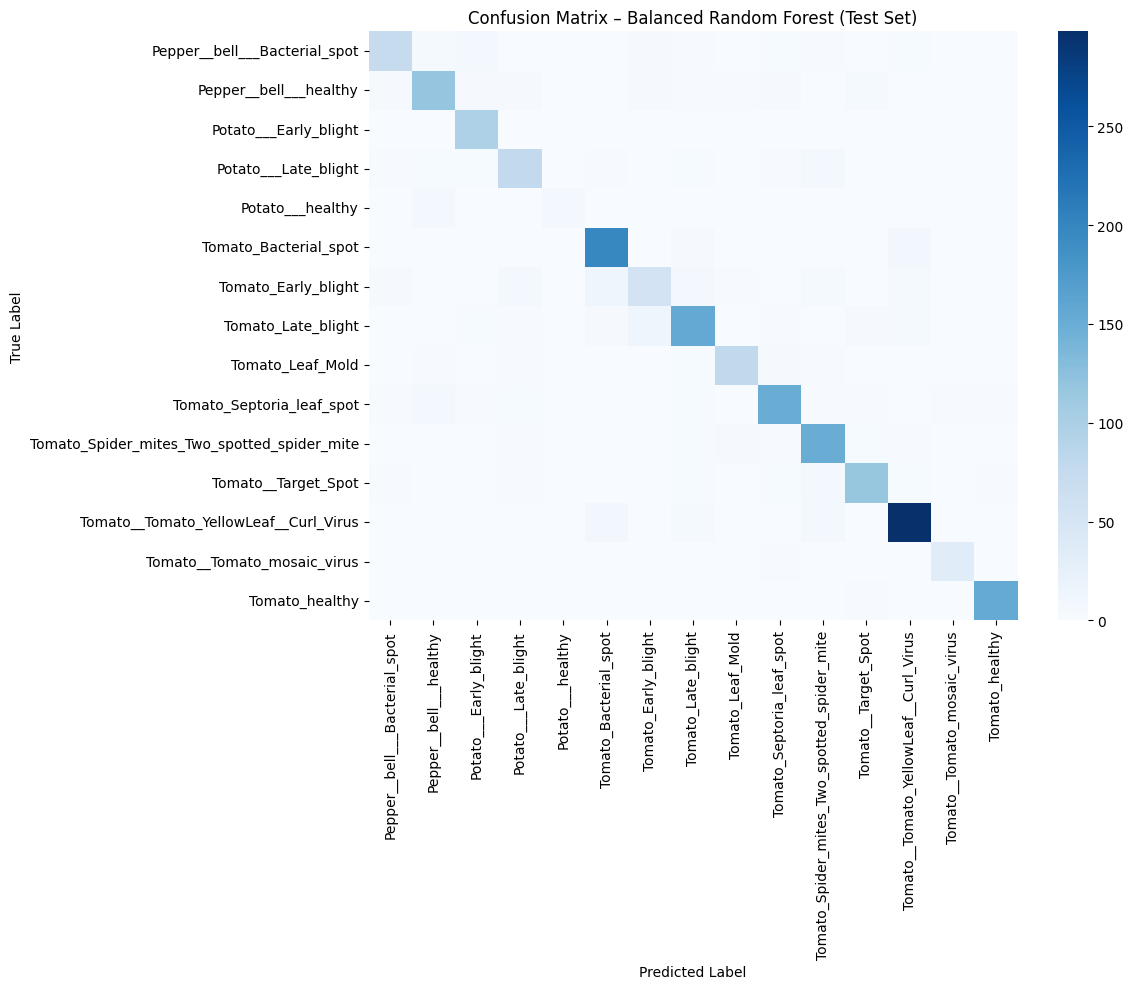

In [30]:
# Final Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_enc, y_test_pred_bal)

plt.figure(figsize=(12,10))
sns.heatmap(
    cm,
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cmap="Blues",
    fmt="d"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Balanced Random Forest (Test Set)")
plt.tight_layout()
plt.show()

In [31]:
# Feature Importance
import numpy as np

feature_names = (
    ["R_mean","R_std","G_mean","G_std","B_mean","B_std"] +
    ["H_mean","H_std","S_mean","S_std","V_mean","V_std"] +
    ["GLCM_contrast","GLCM_dissimilarity","GLCM_homogeneity",
     "GLCM_energy","GLCM_correlation"]
)

importances = rf_balanced.feature_importances_
indices = np.argsort(importances)[::-1]

print("Top 10 important features:")
for i in indices[:10]:
    print(f"{feature_names[i]:25s} {importances[i]:.4f}")

Top 10 important features:
H_mean                    0.1261
H_std                     0.0968
S_std                     0.0668
R_std                     0.0659
S_mean                    0.0640
GLCM_dissimilarity        0.0619
GLCM_contrast             0.0543
B_std                     0.0539
GLCM_correlation          0.0535
G_mean                    0.0521


In [32]:
# Saving mdoel
import joblib

joblib.dump(rf_balanced, "rf_plant_disease_balanced.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Final model, scaler, and label encoder saved")

Final model, scaler, and label encoder saved


In [33]:
from pathlib import Path

MODEL_PATH  = Path("rf_plant_disease_balanced.pkl")
SCALER_PATH = Path("feature_scaler.pkl")
ENC_PATH    = Path("label_encoder.pkl")

print("Saved files:")
print(MODEL_PATH.resolve())
print(SCALER_PATH.resolve())
print(ENC_PATH.resolve())

Saved files:
C:\Users\HP\OneDrive\Apps\Documents\Codes\ML\Plant Disease\rf_plant_disease_balanced.pkl
C:\Users\HP\OneDrive\Apps\Documents\Codes\ML\Plant Disease\feature_scaler.pkl
C:\Users\HP\OneDrive\Apps\Documents\Codes\ML\Plant Disease\label_encoder.pkl


In [34]:
for p in [MODEL_PATH, SCALER_PATH, ENC_PATH]:
    print(p.name, "exists:", p.exists(), "| size (bytes):", p.stat().st_size if p.exists() else 0)


rf_plant_disease_balanced.pkl exists: True | size (bytes): 210674513
feature_scaler.pkl exists: True | size (bytes): 1007
label_encoder.pkl exists: True | size (bytes): 2907
